In [1]:
from prod.set_seed import random_ctl
seed = random_ctl(432286)

from fastai.text import *
from fastai.callbacks import SaveModelCallback
from fastai.layers import LabelSmoothingCrossEntropy

import sentencepiece as spm #https://github.com/google/sentencepiece
import fire

from sp_tok import *
from prod.bin_metrics import Fbeta_binary
from sklearn.model_selection import KFold
from prod.nlp_mixup import *


def split_data_by_idx(all_texts_df:DataFrame, train_idx, valid_idx):                                                                     
    df_train = all_texts_df.iloc[train_idx,:]                                                                                            
    df_valid     = all_texts_df.iloc[valid_idx,:]                                                                                        
                                                                                                                                         
    return df_train, df_valid                                                                                                            


Using seed: 432286


In [2]:
model_path:str='./data/rnn/'
sp_model:str='./all_tweets_es_0609'
qrnn:bool=True
n_hid:int=2304 
load_enc:str='twitter_es_enc_QRNN_0609_drop1_seed0_finetune'
split_seed:int=20190303
wd:float=0.02 ## updated

# def fit_clas(model_path:str, sp_model:str, wd:float=0.,                              
#              qrnn:bool=True, n_hid:int=2304, load_enc:str=None, split_seed:int=None):    

In [3]:
PATH = Path(model_path)                                                                                                              
# torch.backends.cudnn.enabled=False                                                                                                 

defaults.text_spec_tok.append(NL) #add a New Line special char                                                                       
sp_vocab = Vocab( get_itos(sp_model) )                                                                                               
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)                                                           

all_texts_df = pd.read_csv('./data/haha_2019_train.csv')                                                                            
all_texts_df.funniness_average.fillna(0,inplace=True)                                                                                
raw_text = all_texts_df.loc[:,'text']                                                                                                

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")                                                                 
for rule in default_rules: raw_text = raw_text.apply(lambda x: rule(str(x)))                                                         
all_texts_df['new_text'] = raw_text #databunch adds `xxbos` so don't add here                                                        

kfolder = KFold(n_splits=5, random_state=split_seed, shuffle=True)                                                                   
for n_fold, (train_idx,valid_idx) in enumerate(kfolder.split(all_texts_df)):                                                         
    df_train,df_valid = split_data_by_idx(all_texts_df,train_idx,valid_idx)                                                          

    data = TextClasDataBunch.from_df(PATH,df_train,df_valid,                                                                         
                               tokenizer=mycust_tok, vocab=sp_vocab,                                                                 
                               text_cols='new_text', label_cols='funniness_average')                                                 
    config = awd_lstm_clas_config.copy()                                                                                             
    config['qrnn'] = qrnn                                                                                                            
    config['n_hid'] = n_hid    
    config['mixup'] = True    
    print(config)                                                                                                                    
    learn = text_classifier_learner(data, AWD_LSTM_mixup, drop_mult=0.5,pretrained=False,config=config)                                    
    if load_enc : learn.load_encoder(load_enc) 
    break

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.4, 'hidden_p': 0.3, 'input_p': 0.4, 'embed_p': 0.05, 'weight_p': 0.5, 'mixup': True}


In [4]:
learn.callback_fns.append(partial(NLP_MixUpCallback,alpha=0.4,stack_x=False,stack_y=False))

epoch,train_loss,valid_loss,time
0,0.777835,0.656075,00:07
1,0.748778,0.619965,00:07


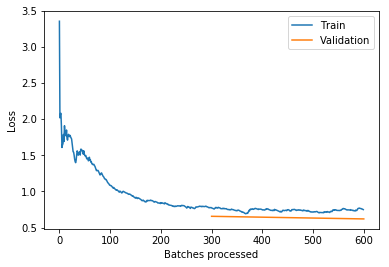

In [5]:
learn.fit_one_cycle(2, 1e-2)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,time
0,0.708039,0.661143,00:07
1,0.719283,0.578918,00:08
2,0.662497,0.578248,00:08


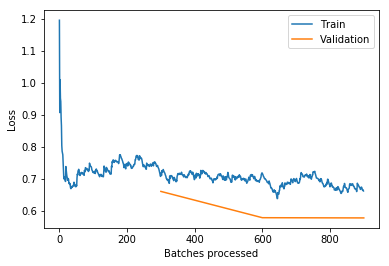

In [6]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.recorder.plot_losses()

In [7]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),5e-3), moms=(0.7,0.4), pct_start=0.25, div_factor=10.,
                    callbacks=[SaveModelCallback(learn,every='improvement',mode='min',                                           
                                                 name='best_vloss_model_Q')])                                                    

epoch,train_loss,valid_loss,time
0,0.654868,0.571819,00:16
1,0.650752,0.568435,00:16
2,0.662535,0.552152,00:16
3,0.639245,0.568289,00:16
4,0.629451,0.542698,00:16
5,0.623469,0.559766,00:16
6,0.604087,0.551205,00:16
7,0.591222,0.561113,00:16
8,0.533330,0.550004,00:16
9,0.524914,0.557284,00:16


Better model found at epoch 0 with valid_loss value: 0.5718190670013428.
Better model found at epoch 1 with valid_loss value: 0.5684348940849304.
Better model found at epoch 2 with valid_loss value: 0.5521522164344788.
Better model found at epoch 4 with valid_loss value: 0.5426976680755615.
